<a href="https://colab.research.google.com/github/yohanesnuwara/differential-equations/blob/master/PDEs/06_PDE_BL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Buckley-Leverett PDE 

(Project by myself)

In [ ]:
import numpy
from matplotlib import pyplot
from scipy import interpolate

pyplot.style.use('seaborn')

The form of BL PDE, according to Brian Towler's textbook p. 159, as follows:

$$\frac{\partial S_w}{\partial t}+\nu_t \frac{\partial F_w}{\partial x}=0$$

Where according to [here](http://sonny-qa.github.io/2017/03/30/Bucky-Leverett-Python/), $\nu_t=\frac{q}{A \phi}$

By my observation, the form above looks like the **transport PDE** form (discussed in my 4th notebook). From of transport PDE is:

$$\frac{\partial \rho}{\partial t}+\frac{\partial F}{\partial x}=0$$

My aim is to solve numerically BL PDE for $S_w(x,t)$, similarly when solving transport PDE for $\rho(x,t)$.

The BL PDE is transformed using chain rule:

$$\frac{\partial S_w}{\partial t}+\nu_t \frac{\partial F_w}{\partial S_w} \frac{\partial S_w}{\partial x}=0$$

Where $F_w=\frac{1}{1+\frac{k_{ro}}{\mu_o} \frac{\mu_w}{k_{rw}}}$

And $k_{ro}, k_{rw}=f(S_w)$

## Relative permeability data

Obtained from Brian Towler's textbook p. 159, Table 13.4

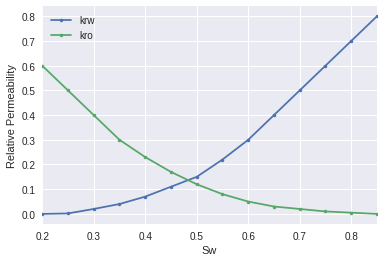

In [ ]:
Sw = numpy.arange(0.2, 0.9, 0.05)
krw = numpy.array([0, .002, .02, .04, .07, .11, .15, .22, .3, .4, .5, .6, .7, .8])
kro = numpy.array([.6, .5, .4, .3, .23, .17, .12, .08, .05, .03, .02, .01, .005, 0])

pyplot.plot(Sw, krw, '.-', label='krw')
pyplot.plot(Sw, kro, '.-', label='kro')
pyplot.xlim(0.2, 0.85)
pyplot.xlabel('Sw'); pyplot.ylabel('Relative Permeability')

pyplot.legend()
pyplot.show()

Interpolate relative permeability data

In [ ]:
def interpolate_kr(Sw, krw, kro):
    # interpolate relative permeability curve
    
    krw_interp = interpolate.splrep(Sw, krw, s=0)
    kro_interp = interpolate.splrep(Sw, kro, s=0)    
    return krw_interp, kro_interp

In [ ]:
krw_interp, kro_interp = interpolate_kr(Sw, krw, kro)

In [ ]:
# test intepolated relperm for Sw=0.575
Sw_new = .575
krw_new = interpolate.splev(Sw_new, krw_interp, der=0)
kro_new = interpolate.splev(Sw_new, kro_interp, der=0)

print('At Sw={}, krw={} and kro={}'.format(Sw_new, krw_new, kro_new))

At Sw=0.575, krw=0.25827076696551754 and kro=0.06379291182871477


## Initial condition

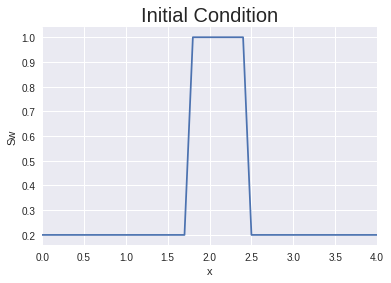

In [ ]:
# set parameters for initial condition
L = 4 
nx = 41

x = numpy.linspace(0.0, L, nx) 
Sw0 = numpy.full(nx, 0.2)
Sw0[[18,19,20,21,22,23,24]] = 1

pyplot.plot(x, Sw0)
pyplot.xlim(min(x), max(x))
pyplot.xlabel('x'); pyplot.ylabel('Sw')
pyplot.title('Initial Condition', size=20)

pyplot.show()

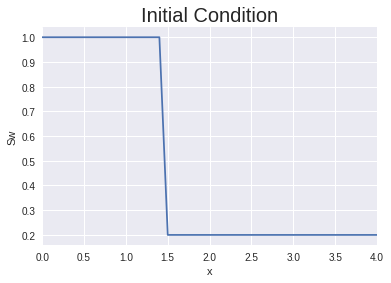

In [ ]:
# set parameters for initial condition
L = 4 
nx = 41

x = numpy.linspace(0.0, L, nx) 
Sw0 = numpy.full(nx, 0.2)
Sw0[:15] = 1

pyplot.plot(x, Sw0)
pyplot.xlim(min(x), max(x))
pyplot.xlabel('x'); pyplot.ylabel('Sw')
pyplot.title('Initial Condition', size=20)

pyplot.show()

# Simulation

Using Forward-time/Backward-space scheme

\begin{equation}
\frac{S^{n+1}_{wi}- S^n_{wi}}{\Delta t}+ \nu_t \frac{F_{wi}^n-F_{wi-1}^n}{\Delta x}=0
\end{equation}

Time extrapolation:

$$S_{wi}^{n+1}=S_{wi}^{n}-\frac{\nu_t \Delta t}{\Delta x} (F_{wi}^{n}-F_{wi-1}^{n})$$

In [ ]:
def interstitial_velocity(q, A, poro):
    # interstitial velocity vt
    vt = q / A * poro
    return vt

def fractional_flow(krw, muw, kro, muo):
    # fractional flow Fww
    Fww = 1 / (1 + (kro / muo) * (muw / krw))
    return Fww

In [ ]:
def BL_cfl(nt, Sw0, L, nx, sigma, bc_value, muw, muo, q, A, poro):
    # Solve Buckley-Leverett PDE using forward-time/backward-space scheme
    
    # calculate interstitial velocity
    vt = interstitial_velocity(q, A, poro)
    
    # calculate dx
    dx = L / (nx - 1)
    
    # calculate dt from CFwL
    dt = sigma * dx / vt  # time-step size 
    
    # Discretize the domain.
    x = numpy.linspace(0.0, L, num=nx)   
    
    # integrate solution in time
    Sw_hist = [Sw0.copy()]
    Sw = Sw0.copy()
    for n in range(nt):
        # Compute the fractional flow.
        krw = interpolate.splev(Sw, krw_interp, der=0) # interpolate krw for updated Sw
        kro = interpolate.splev(Sw, kro_interp, der=0) # interpolate kro for updated Sw
        Fw = fractional_flow(krw, muw, kro, muo)
        
        # Advance in time.
        Sw[1:] = Sw[1:] - (vt * dt / dx) * (Fw[1:] - Fw[:-1])
        
        # Set the left boundary condition.
        Sw[0] = bc_value
        
        # Record the time-step solution.
        Sw_hist.append(Sw.copy()) 

    # Plot Sw over x
    fig = pyplot.figure(figsize=(6.0, 4.0))
    pyplot.xlabel(r'$x$')
    pyplot.ylabel(r'Sw')
    pyplot.grid()
    pyplot.plot(x, Sw0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x, Sw, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.xlim(0.0, L)
    pyplot.ylim(0, 1)
    fig.tight_layout()  
    pyplot.legend()
    pyplot.grid()

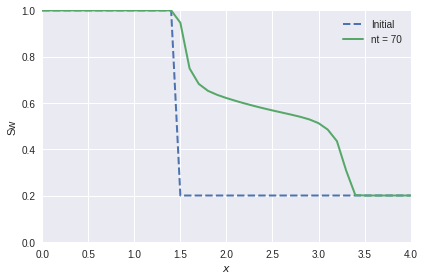

In [ ]:
# Set parameters for simulation
nt = 70
L = 4
sigma = 0.1
bc_value = Sw0[0]
u_max = 1

muw = 0.5E-3
muo = 1E-3
q = 200 # m3/hr
A = 30 # m2
poro = 0.24

# Simulation
BL_cfl(nt, Sw0, L, nx, sigma, bc_value, muw, muo, q, A, poro)

## Producing animation

In [ ]:
from matplotlib import animation
from IPython.display import HTML

In [ ]:
def BL_mov(nt, Sw0, L, nx, sigma, bc_value, muw, muo, q, A, poro):
    # Solve Buckley-Leverett PDE using forward-time/backward-space scheme
    
    # calculate interstitial velocity
    vt = interstitial_velocity(q, A, poro)
    
    # calculate dx
    dx = L / (nx - 1)
    
    # calculate dt from CFwL
    dt = sigma * dx / vt  # time-step size 
    
    # Discretize the domain.
    x = numpy.linspace(0.0, L, num=nx)   
    
    # integrate solution in time
    Sw_hist = [Sw0.copy()]
    Sw = Sw0.copy()
    for n in range(nt):
        # Compute the fractional flow.
        krw = interpolate.splev(Sw, krw_interp, der=0) # interpolate krw for updated Sw
        kro = interpolate.splev(Sw, kro_interp, der=0) # interpolate kro for updated Sw
        Fw = fractional_flow(krw, muw, kro, muo)
        
        # Advance in time.
        Sw[1:] = Sw[1:] - (vt * dt / dx) * (Fw[1:] - Fw[:-1])
        
        # Set the left boundary condition.
        Sw[0] = bc_value
        
        # Record the time-step solution.
        Sw_hist.append(Sw.copy()) 
    
    return x, Sw0, Sw_hist

In [ ]:
sigma=0.5
x, Sw0, Sw_hist = BL_mov(nt, Sw0, L, nx, sigma, bc_value, muw, muo, q, A, poro)

In [ ]:
def update_plot(n, u_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    u_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(u_hist[n])

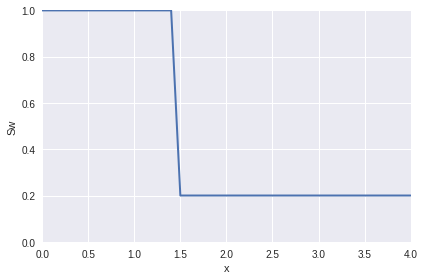

In [ ]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('x')
pyplot.ylabel('Sw')
pyplot.grid()
line = pyplot.plot(x, Sw0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(0, 1)
fig.tight_layout()
pyplot.grid()

In [ ]:
# Create an animation.
nt = 70
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(Sw_hist,),
                               interval=200)

In [ ]:
# Display the video.
HTML(anim.to_html5_video())